(6337, 17)

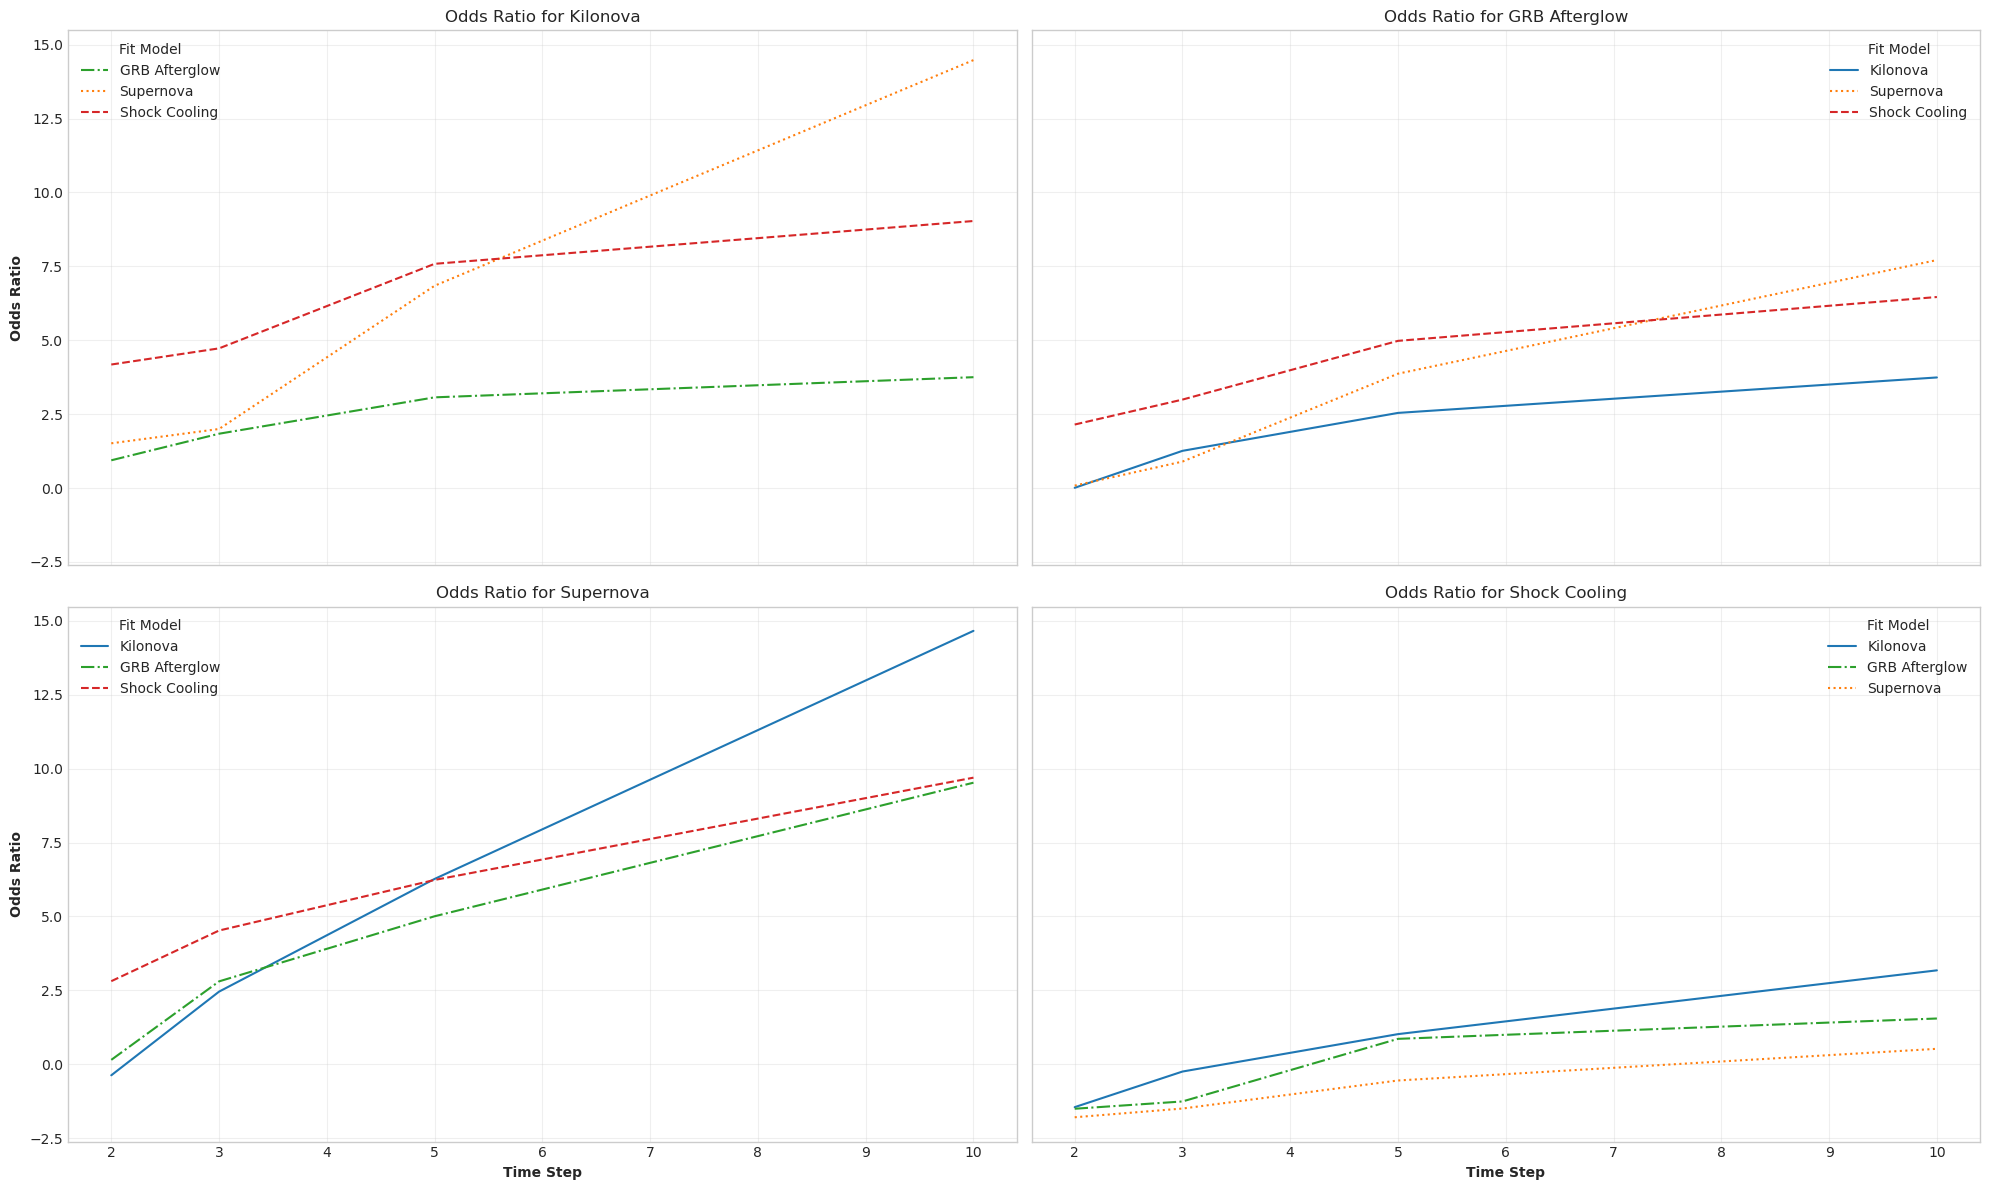

In [39]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
plt.style.context(("seaborn-colorblind",))
plt.rcParams['axes.labelweight'] = 'bold'


df = pd.read_csv('./fit_dataframes/ztf-cadence-100-fit_df.csv')
df = df[df['t_max'] <= 20]
# df21 = pd.read_csv('./fit_dataframes/21-validation-fit_df.csv')
# df = pd.concat([df, df21], ignore_index=True)
df['odds_ratio'] = np.nan
for true_lc in df.true_lightcurve.unique():
    lc_df = df[df.true_lightcurve == true_lc]
    for model in df.fit_model.unique():
        lc_idf = lc_df[lc_df.fit_model == model]
        if lc_idf['true_model'].values[0] == model:
            df.loc[lc_idf.index, 'odds_ratio'] = np.nan
        else:
            correct_bayes_factor = lc_df[(lc_df.fit_model == lc_df.true_model)].log_bayes_factor.values[0]
            df.loc[lc_idf.index, 'odds_ratio'] =  correct_bayes_factor - lc_idf.log_bayes_factor.values[0]

model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
# color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

display(df.shape)

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'log_bayes_factor': 'median'}).reset_index()
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
#color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

fig, axs = plt.subplots(2, 2, figsize=(20, 12),sharex=True, sharey=True)
axs = axs.flatten()
model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# for axi, model in enumerate(grouped_df['true_model'].unique()):
for axi, model in enumerate(model_order):
    iter_df = grouped_df[grouped_df['true_model'] == model]
    
    ax = axs[axi]
    for fit_model in model_order:
        if fit_model != model:
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax.plot(diff_df['t_max'], diff, label=f'{model_dict[fit_model]}', color=color_dict[fit_model], linestyle=ls_dict[fit_model])
            ## plot above using lineplot instead of scatter
            #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')

    ax.set_title(f'Odds Ratio for {model_dict[model]}')
    ## grid lines
    ax.grid(True, alpha=0.3)
    # ax.set_ylim(-1,)

    ax.legend(title='Fit Model')
axs[0].set_ylabel('Odds Ratio'), axs[2].set_ylabel('Odds Ratio')
axs[2].set_xlabel('Time Step'), axs[3].set_xlabel('Time Step')
# axs[0].set_xlim(2,22)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()


figpath = Path('./plots/odds_ratios.pdf')
if not os.path.exists(figpath):
    plt.savefig(figpath, dpi=300)
else:
    input(f'{figpath} already exists. Press enter to overwrite.')
    plt.savefig(figpath, dpi=300)


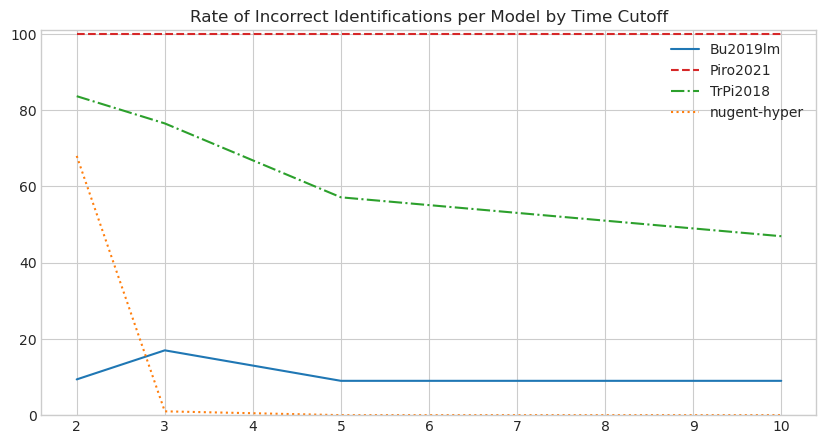

In [40]:
lowest_bayes = []
for lightcurve in  df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().min()].squeeze()
        lowest_bayes.append(lowest_bf_row )

lbf_df = pd.DataFrame(lowest_bayes)     


second_lowest_bayes = []
for lightcurve in df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        second_lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().sort_values().unique()[1]].squeeze()
        second_lowest_bayes.append(second_lowest_bf_row )
scnd_lbf_df = pd.DataFrame(second_lowest_bayes)

third_lowest_bayes = []
for lightcurve in df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        third_lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().sort_values().unique()[2]].squeeze()
        third_lowest_bayes.append(third_lowest_bf_row )
thrd_lbf_df = pd.DataFrame(third_lowest_bayes)

## plot the number of incorrect idenfications per model, grouped by t_max (x-axis)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for model in lbf_df['true_model'].unique():
    model_df = lbf_df[(lbf_df['true_model'] == model)]
    ## count number of incorrect identifications per t_max per model
    incorrect_identifications = []
    for tmax in sorted(model_df['t_max'].unique()):
        tmax_df = model_df[model_df['t_max'] == tmax]
        incorrect_identifications.append(len(tmax_df[tmax_df['fit_model'] != model]) / len(tmax_df)*100)
    ax.plot(sorted(model_df['t_max'].unique()), incorrect_identifications, label=model, linestyle=ls_dict[model], color=color_dict[model])
    ax.legend()
    ax.set_ylim(0, 101)
ax.set_title('Rate of Incorrect Identifications per Model by Time Cutoff')
plt.show()


## from lbf_df, find percentage per model of incorrect identifications, grouped by t_max. there are 100 lightcurves for each model

# for tmax in sorted(lbf_df['t_max'].unique()):
#     print(f'\nFor t_max: {tmax}')
#     for model in lbf_df['true_model'].unique():
#         model_df = lbf_df[(lbf_df['true_model'] == model) & (lbf_df['t_max'] == tmax)]
#         print(f'For true model: {model}, the percentage of incorrect identifications is: {round(len(model_df[model_df["fit_model"] != model]) / len(model_df)*100,1)}')

In [133]:
# import os
# import json
# from pathlib import Path
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator

# import warnings
# warnings.filterwarnings(action='once')
# import warnings
# warnings.simplefilter('ignore', category=FutureWarning)
# plt.style.use('seaborn-whitegrid')
# plt.style.context(("seaborn-colorblind",))
# plt.rcParams['axes.labelweight'] = 'bold'


# df = pd.read_csv('./fit_dataframes/ztf-cadence-100-fit_df.csv')
# # df21 = pd.read_csv('./fit_dataframes/21-validation-fit_df.csv')
# # df = pd.concat([df, df21], ignore_index=True)
# df['odds_ratio'] = np.nan
# for true_lc in df.true_lightcurve.unique():
#     lc_df = df[df.true_lightcurve == true_lc]
#     for model in df.fit_model.unique():
#         lc_idf = lc_df[lc_df.fit_model == model]
#         if lc_idf['true_model'].values[0] == model:
#             df.loc[lc_idf.index, 'odds_ratio'] = np.nan
#         else:
#             correct_bayes_factor = lc_df[(lc_df.fit_model == lc_df.true_model)].log_bayes_factor.values[0]
#             df.loc[lc_idf.index, 'odds_ratio'] = correct_bayes_factor - lc_idf.log_bayes_factor.values[0]

# display(df['odds_ratio'].describe())

# model_dict = {'Bu2019lm':'Kilonova', 
#               'TrPi2018':'GRB Afterglow',
#               'Piro2021':'Shock Cooling',
#               'nugent-hyper':'Supernova'}
# # color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

# current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# # Generate a dictionary of colors
# color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

# display(df.shape)

# grouped_df = df.groupby(['t_max', 'true_model', 'fit_model']).agg({'odds_ratio': 'median'}).reset_index()
# ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
# #color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

# fig, axs = plt.subplots(2, 2, figsize=(10, 6),sharex=True, sharey=True)
# axs = axs.flatten()
# model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# # for axi, model in enumerate(grouped_df['true_model'].unique()):
# for axi, model in enumerate(model_order):
#     iter_df = grouped_df[grouped_df['true_model'] == model]
    
#     ax = axs[axi]
#     for fit_model in model_order:
#         if fit_model != model:
#             diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
#             #diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
#             ax.plot(diff_df['t_max'], diff_df['odds_ratio'], label=f'{model_dict[fit_model]}', color=color_dict[fit_model], linestyle=ls_dict[fit_model])
#             ## plot above using lineplot instead of scatter
#             #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')

#     ax.set_title(f'Odds Ratio for {model_dict[model]}')
#     ## grid lines
#     ax.grid(True, alpha=0.3)
#     # ax.set_ylim(-1,)

#     ax.legend(title='Fit Model')
# axs[0].set_ylabel('Odds Ratio'), axs[2].set_ylabel('Odds Ratio')
# axs[2].set_xlabel('Time Step'), axs[3].set_xlabel('Time Step')
# # axs[0].set_xlim(2,22)
# axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.tight_layout()


# # figpath = Path('./plots/odds_ratios_with21.pdf')
# # if not os.path.exists(figpath):
# #     plt.savefig(figpath, dpi=300)
# # else:
# #     input(f'{figpath} already exists. Press enter to overwrite.')
# #     plt.savefig(figpath, dpi=300)


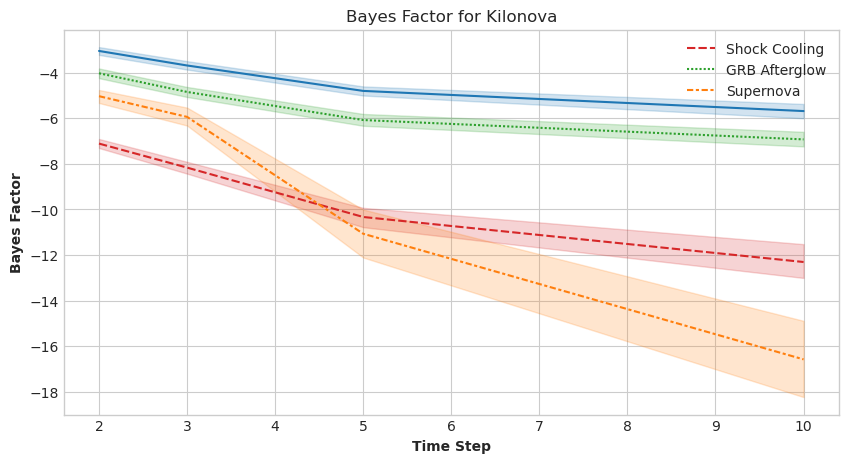

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x='t_max', y='log_bayes_factor', hue='fit_model', data=df[df['true_model']=='Bu2019lm'], style='fit_model', palette=color_dict, ax =ax)
ax.set_title('Bayes Factor for Kilonova')
ax.set_xlabel('Time Step')
ax.set_ylabel('Bayes Factor')
ax.legend(title='Fit Model')
## rename the labels based on the model_dict
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=[model_dict[label] for label in labels[1:]])
plt.show()

<Figure size 1200x800 with 0 Axes>

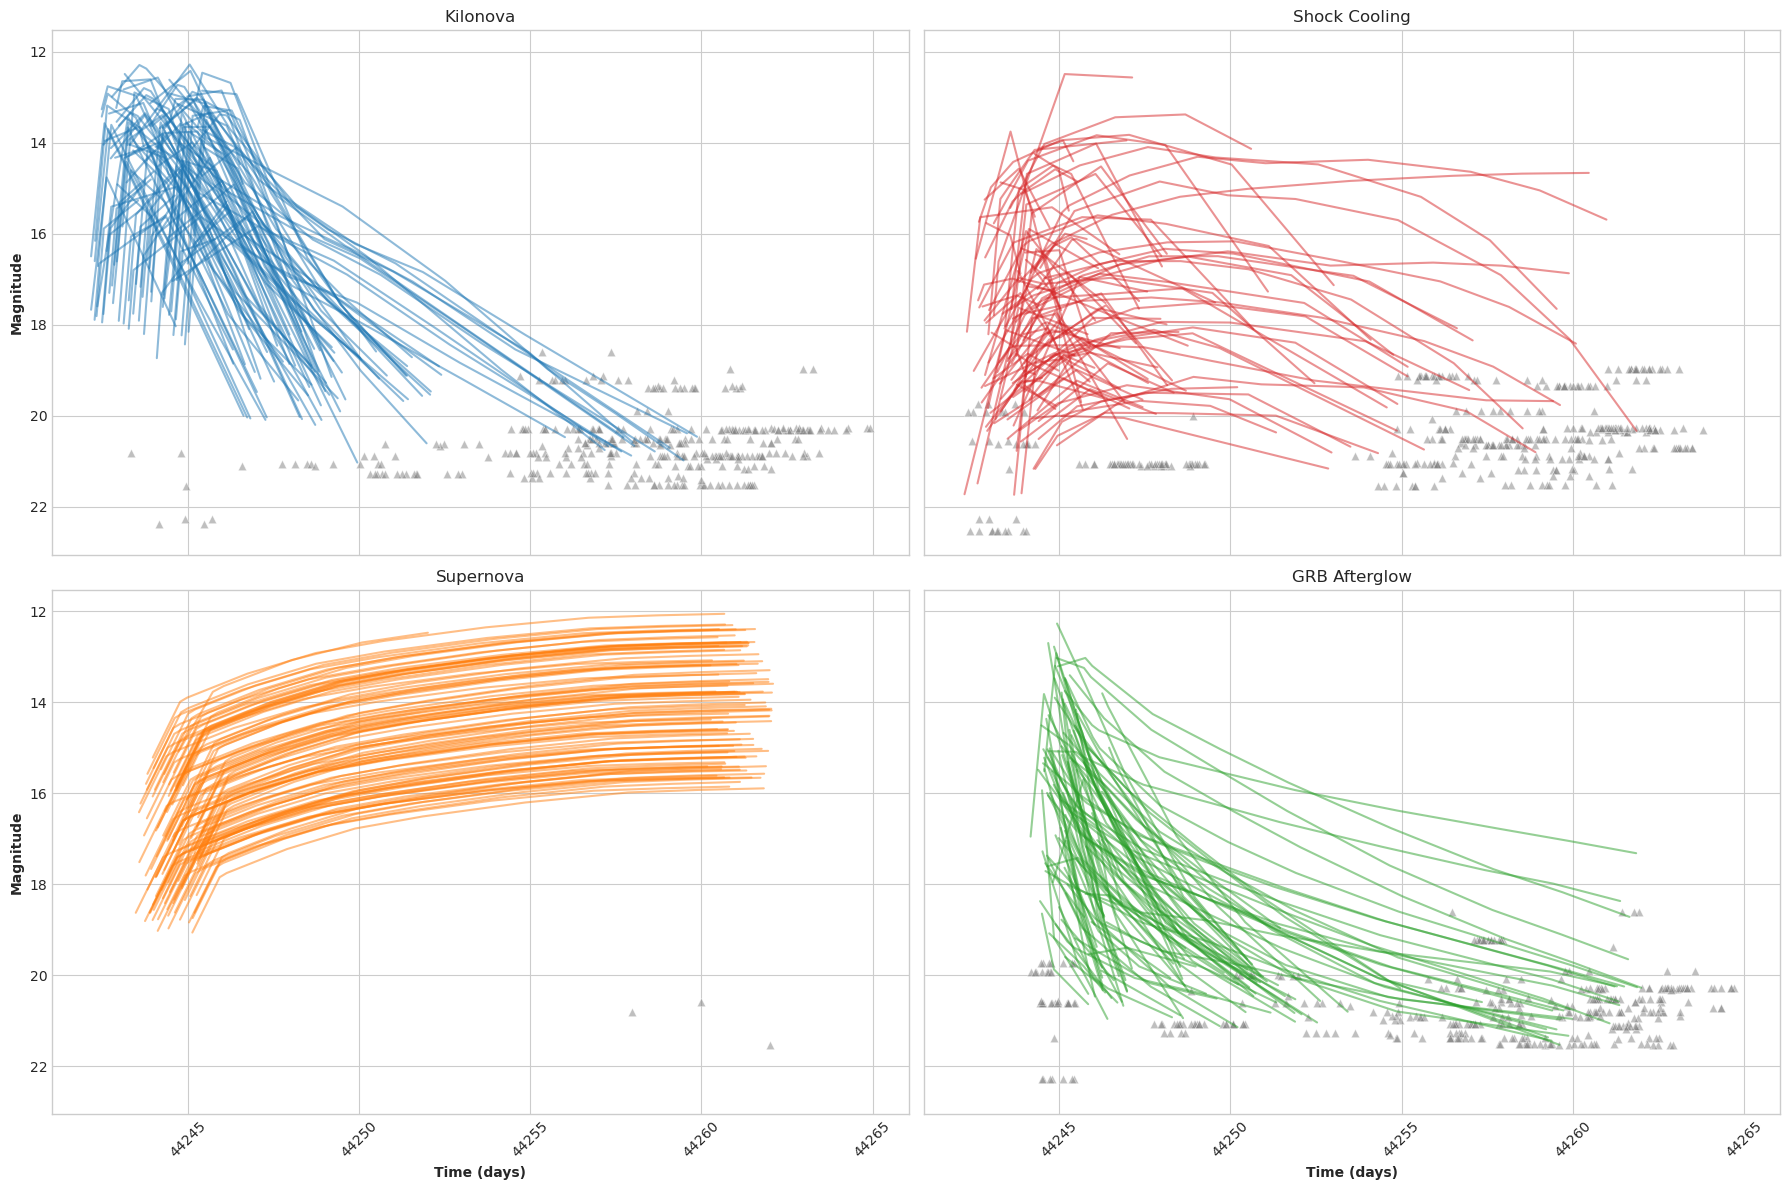

In [25]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'injections/ztf-cadence-100/'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].append(ztfg_data)


model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
# color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
fig, axs = plt.subplots(rows, 2, figsize=(18, 12), sharex=True, sharey=True)
axs = axs.flatten()
i_df = [pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]) for lc_data in model_data['Bu2019lm']]
ii_df = pd.concat(i_df, ignore_index=True)
t_min = ii_df['Time'].min()
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = axs[i] #plt.subplot(rows, 2, i + 1, sharex=plt)
    color = color_dict[model_name]
    i_df = [pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]) for lc_data in lc_list]
    ii_df = pd.concat(i_df, ignore_index=True)
    t_min = ii_df['Time'].min()
    # for ii_df in i_df:
        # ii_df['Time'] = ii_df['Time'] - t_min
    # [sns.lineplot(data=data_frame[data_frame['Time'] <= data_frame['Time'].values[0]+1.5], x="Time", y="Value", alpha=0.3, color='grey', ax=ax) 
    #  for data_frame in i_df]
    # [sns.lineplot(data=data_frame[(data_frame['Time'] >= data_frame['Time'].values[0]+1.5) & (data_frame['Time'] <= data_frame['Time'].values[0]+10)], x="Time", y="Value", alpha=0.5, color=color, ax=ax) 
    #  for data_frame in i_df]
    # [sns.lineplot(data=data_frame[data_frame['Time'] >= data_frame['Time'].values[0]+10], x="Time", y="Value", alpha=0.3, color='grey', ax=ax) 
    #  for data_frame in i_df]
    [sns.scatterplot(data=data_frame[(data_frame['Time'] > 0 ) & (data_frame['Uncertainty'] == np.inf)], x="Time", y="Value", alpha=0.5, color='grey', marker='^', ax=ax) for data_frame in i_df]
    [sns.lineplot(data=data_frame[(data_frame['Time'] > 0) & (data_frame['Uncertainty']!= np.inf )], x="Time", y="Value", alpha=0.5, color=color, ax=ax) 
     for data_frame in i_df]
    
    ax.set_title(model_dict[model_name])
    # plt.xlabel("Time")
    # plt.ylabel("Value")
    # ax.invert_yaxis()
    # min_time = min([pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"])["Time"].min() for lc_data in lc_list])
    # ax.set_xlim(min_time+1.5)
    ## make x axis labels rotated by 45 degrees
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
axs[0].invert_yaxis()
axs[0].set_ylabel('Magnitude')
axs[2].set_ylabel('Magnitude')
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')
plt.tight_layout()
plt.show()

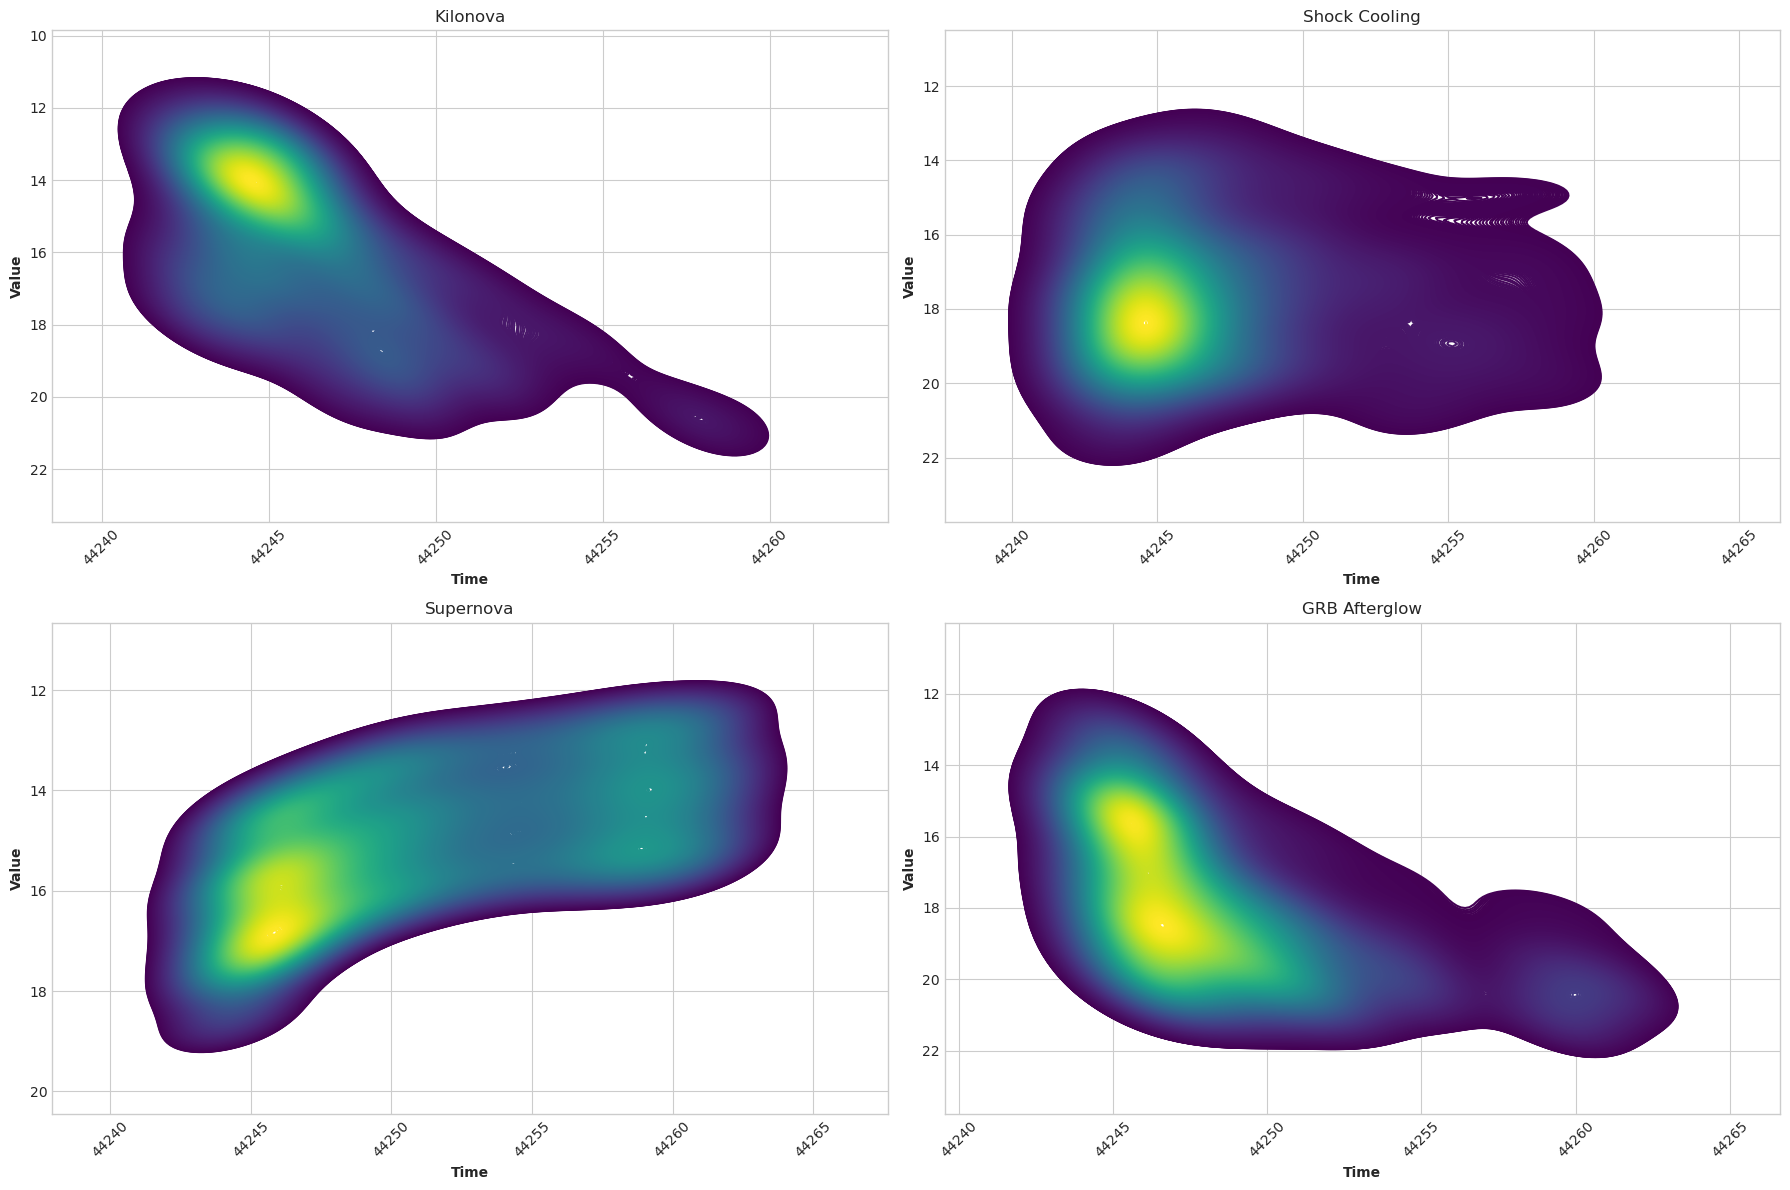

In [26]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
# color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

folder_path = 'injections/ztf-cadence-100/'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].extend(ztfg_data)  # Extend instead of append

plt.figure(figsize=(18, 12))

# Determine the number of rows for subplots
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2

for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    color = color_dict[model_name]

    # Create a Pandas DataFrame for the combined data for each model
    combined_df = pd.DataFrame(lc_list, columns=["Time", "Value", "Uncertainty"])
    combined_df = combined_df[combined_df['Uncertainty'] != np.inf]
    # Use Seaborn's KDE plot to visualize the density
    sns.kdeplot(data=combined_df,
                x="Time", y="Value", cmap="viridis", fill=False, color=color, levels=2000)
    ## also plot the median lightcurve (found by taking median of each time step)
    median_df = combined_df.groupby('Time').median().reset_index()
    # ax.plot(median_df['Time'], median_df['Value'], color=color, linestyle='--', linewidth=2)

    plt.title(model_dict[model_name])
    plt.xlabel("Time")
    plt.ylabel("Value")

    ax.invert_yaxis()

    # Make x-axis labels rotated by 45 degrees
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

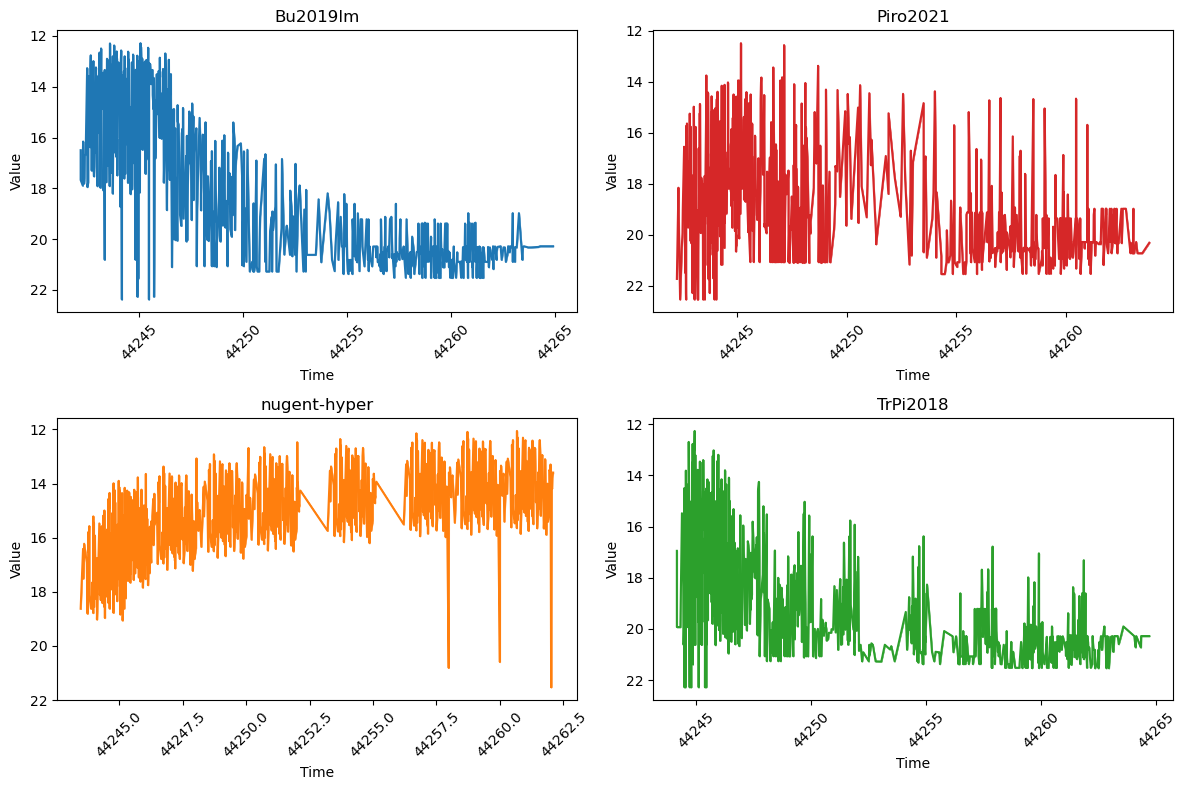

In [23]:
plt.figure(figsize=(12, 8))

# Determine the number of rows for subplots
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2

for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    color = color_dict[model_name]

    # Create a Pandas DataFrame for the combined data for each model
    combined_df = pd.DataFrame(lc_list, columns=["Time", "Value", "Uncertainty"])

    # Calculate the median and quartiles for the light curves
    median_lc = combined_df.groupby("Time")["Value"].quantile(0.50)
    q1 = combined_df.groupby("Time")["Value"].quantile(0.25)
    q3 = combined_df.groupby("Time")["Value"].quantile(0.75)

    # Plot the median light curve
    ax.plot(median_lc.index, median_lc.values, color=color, label="Median")
    # ax.plot(median_lc.index, q1, color=color, linestyle="--", label="25%")
    # ax.plot(median_lc.index, q3, color=color, linestyle="--", label="75%")

    # Shade the area between quartiles
    ax.fill_between(median_lc.index, q1, q3, color=color, alpha=0.5, label="IQR (25%-75%)")

    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()

    # Make x-axis labels rotated by 45 degrees
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

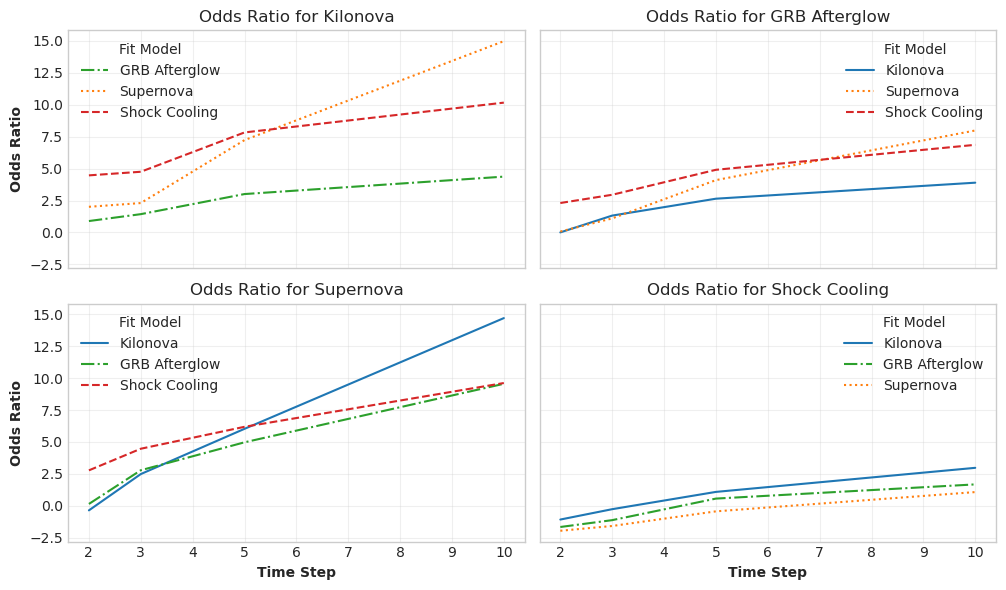

In [24]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
plt.style.context(("seaborn-colorblind",))
plt.rcParams['axes.labelweight'] = 'bold'


df = pd.read_csv('./fit_dataframes/model-recovery-ignore-first-fit_df.csv')
df = pd.read_csv('./fit_dataframes/ztf-cadence-100-fit_df.csv')
# df21 = pd.read_csv('./fit_dataframes/21-validation-fit_df.csv')
# df = pd.concat([df, df21], ignore_index=True)
# display(df)

model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

# Calculate the odds ratios for each combination and then take the median

df['odds_ratio'] = np.nan
for lightcurve in df['lightcurve'].unique():
    lc_df = df[df['lightcurve'] == lightcurve]
    for row in lc_df.index:
        true_model = lc_df.loc[row, 'true_model']
        fit_model = lc_df.loc[row, 'fit_model']
        if true_model == fit_model:
            df.loc[row, 'odds_ratio'] = np.NaN
        else:
            df.loc[row, 'odds_ratio'] = lc_df[lc_df['fit_model'] == true_model]['log_bayes_factor'].iloc[0] - lc_df.loc[row, 'log_bayes_factor']
# display(df['odds_ratio'].describe())

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'odds_ratio': 'median'}).reset_index()
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
#color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

fig, axs = plt.subplots(2, 2, figsize=(10, 6),sharex=True, sharey=True)
axs = axs.flatten()
model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# for axi, model in enumerate(grouped_df['true_model'].unique()):
for axi, model in enumerate(model_order):
    # print('\n\ntrue model', model)
    iter_df = grouped_df[grouped_df['true_model'] == model]
    ax = axs[axi]
    for fit_model in model_order:
        if fit_model != model:
            # print('fit model', fit_model)
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            # display(diff_df['odds_ratio'].describe())
            # diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax.plot(diff_df['t_max'], diff_df['odds_ratio'], label=f'{model_dict[fit_model]}', color=color_dict[fit_model], linestyle=ls_dict[fit_model])
            ## plot above using lineplot instead of scatter
            #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')

    ax.set_title(f'Odds Ratio for {model_dict[model]}')
    ## grid lines
    ax.grid(True, alpha=0.3)

    ax.legend(title='Fit Model')
axs[0].set_ylabel('Odds Ratio'), axs[2].set_ylabel('Odds Ratio')
axs[2].set_xlabel('Time Step'), axs[3].set_xlabel('Time Step')
# axs[0].set_xlim(2,22)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

count    6337.000000
mean      188.346542
std       268.781100
min         0.000000
25%        26.049824
50%        81.844324
75%       232.453423
max      2834.342625
Name: residual, dtype: float64

In [168]:
# lowest_residual = []
# for lightcurve in  df['lightcurve'].unique():
#     for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
#         iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
#         if iterative_df['residual'].abs().min():
#             lowest_residual_row = iterative_df[iterative_df['residual'] == iterative_df['residual'].min()].squeeze()
#             lowest_residual.append(lowest_residual_row )


# lr_df = pd.DataFrame(lowest_residual)  

# model_dict = {
#     'Bu2019lm': 'Kilonova',
#     'TrPi2018': 'GRB Afterglow',
#     'Piro2021': 'Shock Cooling',
#     'nugent-hyper': 'Supernova'
# }

# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# tmax_array = [2, 3, 5, 10]
# fig, axes = plt.subplots(1, len(tmax_array), figsize=(4.333*len(tmax_array), 5), gridspec_kw={'width_ratios': [1]*len(tmax_array)})
# all_model_combinations = [(true, fit) for true in model_dict.keys() for fit in model_dict.keys()]

# ## Iterate over the sorted unique values of t_max and create a subplot for each
# for i, tmax in enumerate(sorted(tmax_array)):
#     tmax_df = lr_df[lr_df['t_max'] == tmax]
#     heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
#     heatmap_data = heatmap_data.reindex(index=model_dict.keys(), columns=model_dict.keys(), fill_value=0)
#     heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0).multiply(100)
#     heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)

#     ## Generate annotation data with percentage signs
#     annotations = heatmap_data.applymap("{:.0f}%".format)

#     ax = axes[i]
#     sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="YlGnBu", norm=Normalize(vmin=0, vmax=100), ax=ax,
#                 cbar=i == len(tmax_array) - 1,
#                 cbar_ax=None if i != len(tmax_array) - 1 else make_axes_locatable(axes[i]).append_axes("right", size="5%", pad=0.1))

#     ax.set_title(f'{int(tmax)} Days of Observation')
#     ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
#     ax.set_xlabel('Best Fit Model')

#     if i == 0:
#         ax.set_yticklabels(heatmap_data.index, rotation=0)
#         ax.set_ylabel('True Model')
#     else:
#         ax.set_yticklabels([])
#         ax.set_ylabel('')

# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 25, 50, 75, 100])
# cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
# fig.tight_layout()

# # figpath = Path('./plots/conf_matrix_combined.pdf')
# # if not os.path.exists(figpath):
# #     plt.savefig(figpath, dpi=300)
# # else:
# #     input(f'{figpath} already exists. Press enter to overwrite.')
# #     plt.savefig(figpath, dpi=300)


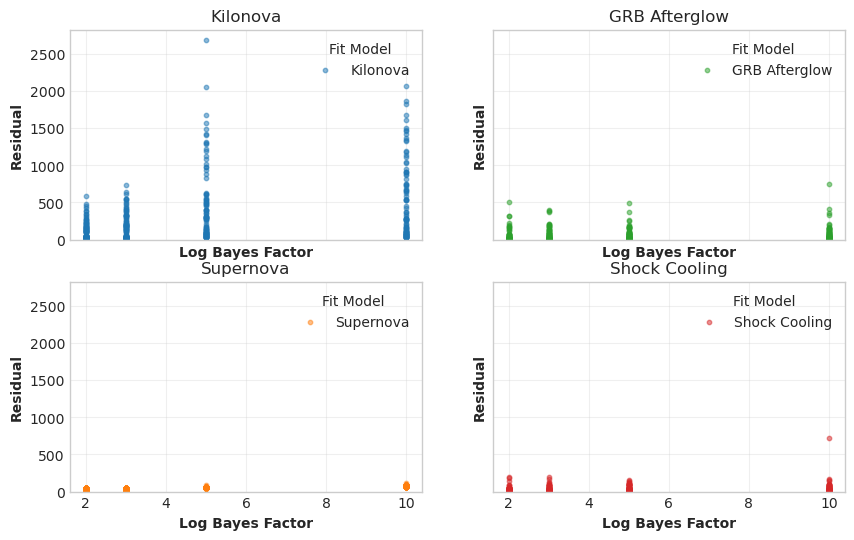

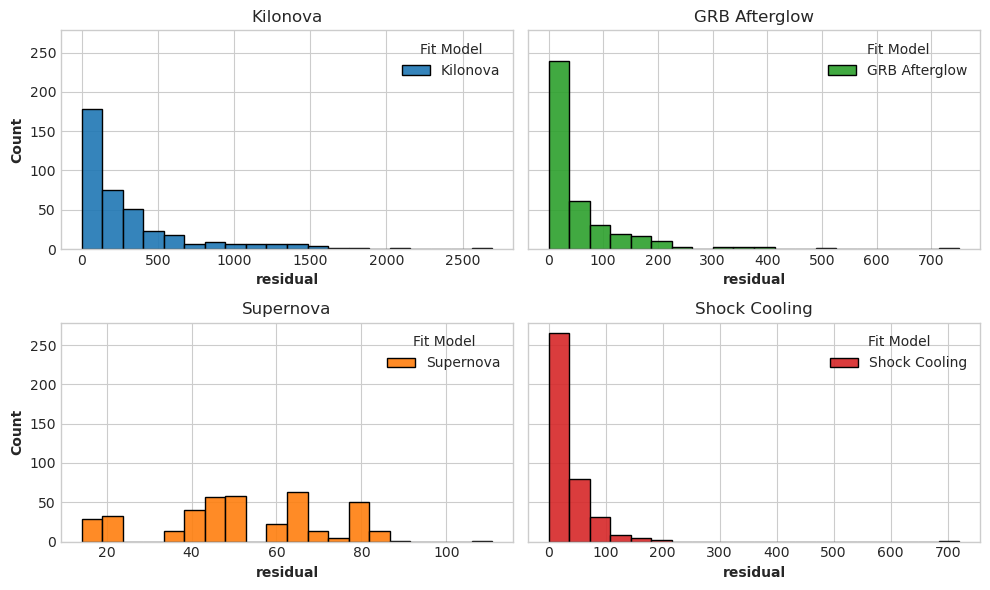

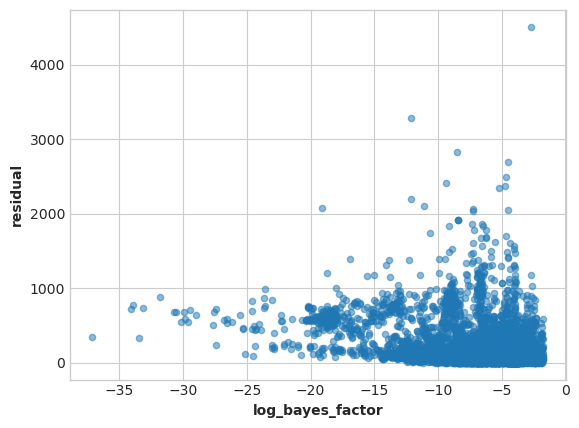

In [125]:
import seaborn as sns
df = pd.read_csv('./fit_dataframes/ztf-cadence-100-fix-chi2-fit_df.csv')
df = df[df['t_max'] <= 20]
## plot the log bayes factor vs the residual for each model
fig, axs = plt.subplots(2, 2, figsize=(10, 6),sharex=True, sharey=True)
fig2, axs2 = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
axs = axs.flatten()
axs2 = axs2.flatten()
model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# for axi, model in enumerate(grouped_df['true_model'].unique()):
for axi, model in enumerate(model_order):
    iter_df = df[df['true_model'] == model]
    ax = axs[axi]
    ax2 = axs2[axi]
    for fit_model in model_order:
        if fit_model == model:
            diff_df = iter_df[iter_df['fit_model'] == fit_model]
            ax.scatter(diff_df['log_bayes_factor'], diff_df['residual'], label=f'{model_dict[fit_model]}', color=color_dict[fit_model], s=10, alpha=0.5)
            ## plot above using lineplot instead of scatter
            #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')
            ax.set_xlabel('Log Bayes Factor')
            ax.set_ylabel('Residual')
            sns.histplot(data=diff_df, x='residual', ax=ax2, color=color_dict[fit_model], label=f'{model_dict[fit_model]}', alpha=0.9, bins=20,multiple='stack')
        else:
        ## plot histogram of residuals
            diff_df = iter_df[iter_df['fit_model'] == fit_model]
            sns.histplot(data=diff_df, x='residual', ax=ax2, color=color_dict[fit_model], label=f'{model_dict[fit_model]}', alpha=0.5, bins=20,multiple='stack')

    ax.set_title(f'{model_dict[model]}')
    ## grid lines
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1,)
    ax2.legend(title='Fit Model')
    ax2.set_title(f'{model_dict[model]}')
    fig2.tight_layout()
    ax.legend(title='Fit Model')
plt.show()

df.plot(kind='scatter', x='log_bayes_factor', y='residual', alpha=0.5)
df = pd.read_csv('./fit_dataframes/ztf-cadence-100-fit_df.csv')

In [150]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize

# model_dict = {
#     'Bu2019lm': 'Kilonova',
#     'TrPi2018': 'GRB Afterglow',
#     'Piro2021': 'Shock Cooling',
#     'nugent-hyper': 'Supernova'
# }

# for tmax in sorted(lbf_df['t_max'].unique()):
# # for tmax in sorted([21]):
#     try:
#         tmax_df = lbf_df[lbf_df['t_max'] == tmax]
        
        
#         # Create the heatmap data and replace the index/column names using model_dict
#         heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
#         heatmap_data = heatmap_data.apply(lambda x: x / x.sum(), axis=1)
#         heatmap_data = heatmap_data.reindex(index=model_dict.keys(), columns=model_dict.keys(), fill_value=0)
#         heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)

#         # Create the heatmap
#         fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
#         sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",  norm=Normalize(vmin=0, vmax=1), ax=ax)

#         # Set the title for the axes
#         ax.set_title(f'{int(tmax)} Days of Observation')

#         # Set the new labels for the axes
#         ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
#         ax.set_yticklabels(heatmap_data.index, rotation=0)
#         ax.set_xlabel('Best Fit Model')
#         ax.set_ylabel('True Model')
        
#         fig.tight_layout()
#         plt.show()
#     except:
#         continue


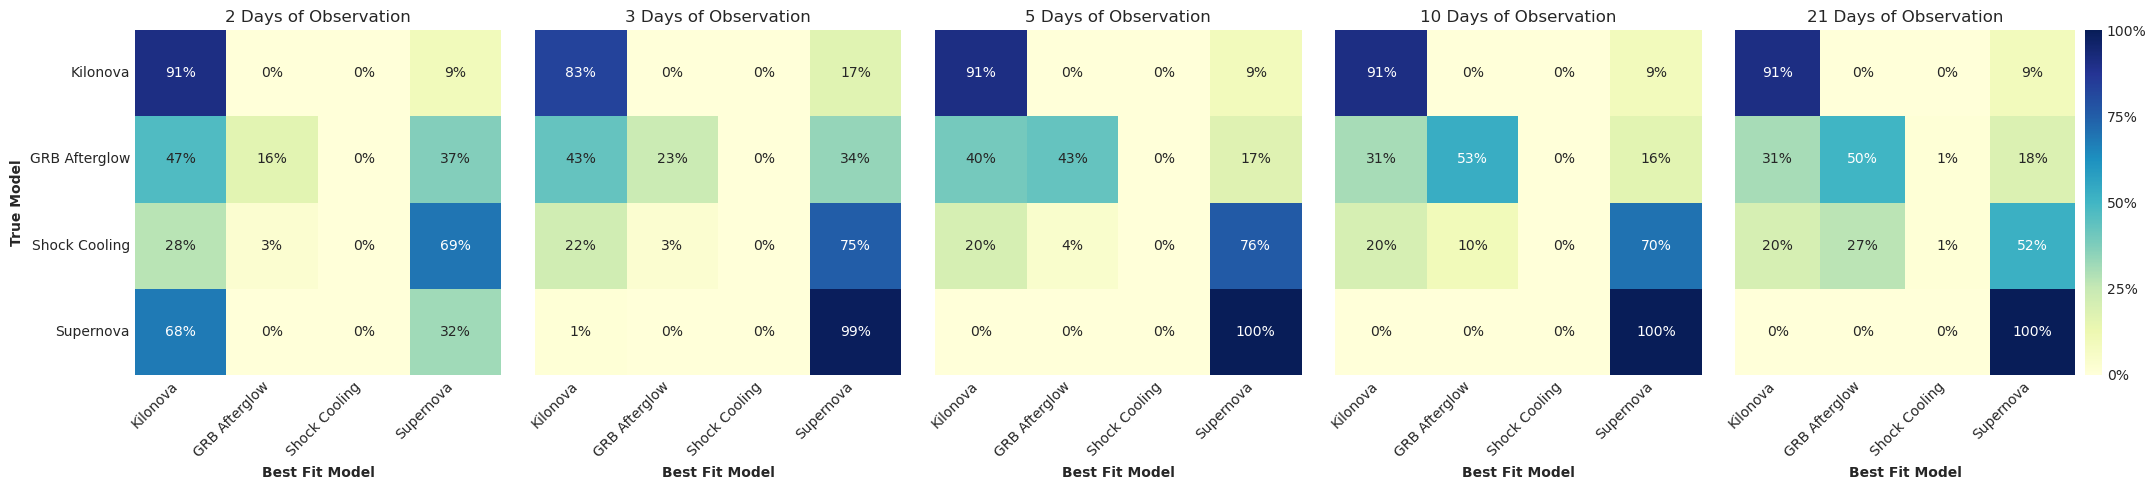

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from pathlib import Path

model_dict = {
    'Bu2019lm': 'Kilonova',
    'TrPi2018': 'GRB Afterglow',
    'Piro2021': 'Shock Cooling',
    'nugent-hyper': 'Supernova'
}


tmax_array = [2, 3, 5, 10,21]
fig, axes = plt.subplots(1, len(tmax_array), figsize=(4.333*len(tmax_array), 5), gridspec_kw={'width_ratios': [1]*len(tmax_array)})
all_model_combinations = [(true, fit) for true in model_dict.keys() for fit in model_dict.keys()]

## Iterate over the sorted unique values of t_max and create a subplot for each
for i, tmax in enumerate(sorted(tmax_array)):
    tmax_df = lbf_df[lbf_df['t_max'] == tmax]
    heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
    heatmap_data = heatmap_data.reindex(index=model_dict.keys(), columns=model_dict.keys(), fill_value=0)
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0).multiply(100)
    heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)

    ## Generate annotation data with percentage signs
    annotations = heatmap_data.applymap("{:.0f}%".format)

    ax = axes[i]
    sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="YlGnBu", norm=Normalize(vmin=0, vmax=100), ax=ax,
                cbar=i == len(tmax_array) - 1,
                cbar_ax=None if i != len(tmax_array) - 1 else make_axes_locatable(axes[i]).append_axes("right", size="5%", pad=0.1))

    ax.set_title(f'{int(tmax)} Days of Observation')
    ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
    ax.set_xlabel('Best Fit Model')

    if i == 0:
        ax.set_yticklabels(heatmap_data.index, rotation=0)
        ax.set_ylabel('True Model')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
fig.tight_layout()

figpath = Path('./plots/conf_matrix_combined.pdf')
if not os.path.exists(figpath):
    plt.savefig('./plots/conf_matrix_combined.pdf', dpi=300)
else:
    input(f'{figpath} already exists. Press enter to overwrite.')
    plt.savefig('./plots/conf_matrix_combined.pdf', dpi=300)


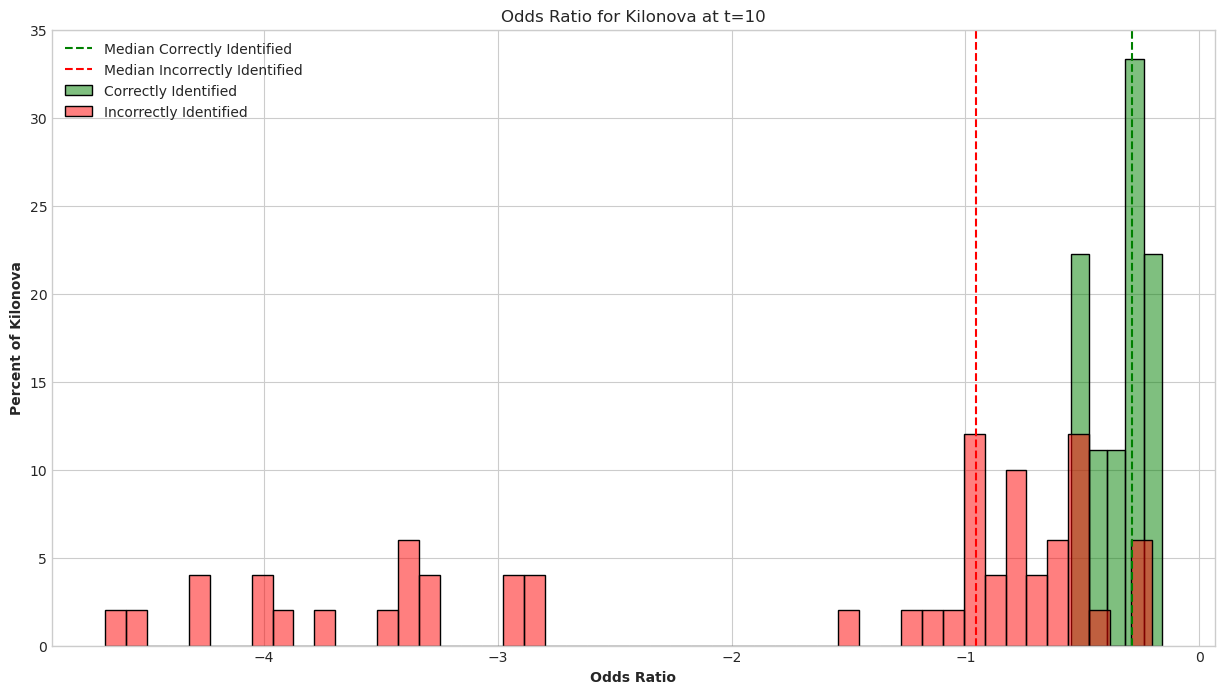

In [47]:
## for t=2, plot a histogram of the odds_ratios for the kilonova that are correctly identified as kilonova vs the falsely identified kilonova
tmax = 10
model_type = 'Bu2019lm'
tmax_df = lbf_df[lbf_df['t_max'] == tmax]
kilonova_df = tmax_df[tmax_df['fit_model'] == model_type]
correct_kilonova = tmax_df[tmax_df['true_model'] == model_type]
incorrect_kilonova = kilonova_df[kilonova_df['true_model'] != model_type]
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.histplot(data=correct_kilonova, x='odds_ratio', ax=ax, color='green', label='Correctly Identified', alpha=0.5, stat='percent', bins=5)

sns.histplot(data=incorrect_kilonova, x='odds_ratio', ax=ax, color='red', label='Incorrectly Identified', alpha=0.5, stat='percent',bins=50)
plt.axvline(correct_kilonova['odds_ratio'].median(), color='green', linestyle='--', label='Median Correctly Identified')
plt.axvline(incorrect_kilonova['odds_ratio'].median(), color='red', linestyle='--', label='Median Incorrectly Identified')
ax.set_title(f'Odds Ratio for {model_dict[model_type]} at t={tmax}')
ax.set_xlabel('Odds Ratio')
ax.set_ylabel('Percent of Kilonova')
ax.legend()

<AxesSubplot:xlabel='odds_ratio', ylabel='true_model'>

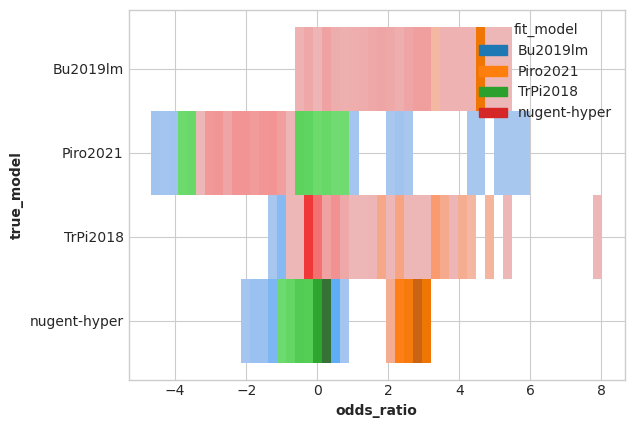

In [54]:
sns.histplot(data=df, x='odds_ratio', y='true_model',hue='fit_model', 
             stat='percent', bins=50, )

In [164]:
scnd_lbf_df[scnd_lbf_df['true_model']=='Piro2021']
p21_lbf_df = lbf_df[lbf_df['true_model']=='Piro2021']
p21_scnd_lbf_df = scnd_lbf_df[scnd_lbf_df['true_model']=='Piro2021']
for tmax in sorted(p21_scnd_lbf_df['t_max'].unique()):
    iter_df = p21_scnd_lbf_df[p21_scnd_lbf_df['t_max'] == tmax]
    ## count how many per timestep have fit_model == true_model
    print(f'For t_max: {tmax}, the percentage of identifications where Piro2021 is the second best model is: {round(len(iter_df[iter_df["fit_model"] == iter_df["true_model"]]) / len(iter_df)*100,1)}')

## do the same for third best model
print()
p21_thrd_lbf_df = thrd_lbf_df[thrd_lbf_df['true_model']=='Piro2021']
for tmax in sorted(p21_thrd_lbf_df['t_max'].unique()):
    iter_df = p21_thrd_lbf_df[p21_thrd_lbf_df['t_max'] == tmax]
    ## count how many per timestep have fit_model == true_model
    print(f'For t_max: {tmax}, the percentage of identifications where Piro2021 is the third best model is: {round(len(iter_df[iter_df["fit_model"] == iter_df["true_model"]]) / len(iter_df)*100,1)}')

For t_max: 2.0, the percentage of identifications where Piro2021 is the second best model is: 6.1
For t_max: 3.0, the percentage of identifications where Piro2021 is the second best model is: 9.0
For t_max: 5.0, the percentage of identifications where Piro2021 is the second best model is: 9.0
For t_max: 10.0, the percentage of identifications where Piro2021 is the second best model is: 9.0
For t_max: 21.0, the percentage of identifications where Piro2021 is the second best model is: 20.0

For t_max: 2.0, the percentage of identifications where Piro2021 is the third best model is: 18.4
For t_max: 3.0, the percentage of identifications where Piro2021 is the third best model is: 26.0
For t_max: 5.0, the percentage of identifications where Piro2021 is the third best model is: 38.0
For t_max: 10.0, the percentage of identifications where Piro2021 is the third best model is: 45.0
For t_max: 21.0, the percentage of identifications where Piro2021 is the third best model is: 40.0


In [166]:
## for each the piro2021 lightcurves in p21_lbf_df and p21_scnd_lbf_df at each timestep where the value of true_model is not Piro2021 in lbf_df, plot the difference between the log_bayes_factor in p21_lbf_df and p21_scnd_lbf_df

for tmax in sorted(p21_scnd_lbf_df['t_max'].unique()):
    iter_first_df = p21_lbf_df[p21_lbf_df['t_max'] == tmax]
    iter_scnd_df = p21_scnd_lbf_df[p21_scnd_lbf_df['t_max'] == tmax]
    iter_third_df = p21_thrd_lbf_df[p21_thrd_lbf_df['t_max'] == tmax]
    ## calculate median difference in log_bayes_factor for each lightcurve
    odds_ratio = []
    first_bf = []
    first_model = []
    scnd_bf = []
    scnd_model = []
    odds_ratio_lcs = []
    num_correct = 0
    num_total = 0
    num_scnd_correct = 0
    num_third_correct = 0
    print(f'\nFor t_max = {tmax}:')
    for lc in iter_first_df['lightcurve'].unique():
        first_df = iter_first_df[iter_first_df['lightcurve'] == lc]
        scnd_df = iter_scnd_df[iter_scnd_df['lightcurve'] == lc]
        third_df = iter_third_df[iter_third_df['lightcurve'] == lc]
        num_total += 1
        if scnd_df['fit_model'].values[0] == 'Piro2021':
            num_scnd_correct += 1
        elif third_df['fit_model'].values[0] == 'Piro2021':
            num_third_correct += 1
        if first_df['fit_model'].values[0] == 'Piro2021':
            # print('for lightcurve: ', lc, 'the first best model is Piro2021')
            num_correct += 1
            continue
        elif scnd_df['fit_model'].values[0] != 'Piro2021':
            continue
        else:
            # print(first_df['fit_model'].values[0])
            first_bf.append(first_df['log_bayes_factor'].values[0])
            scnd_bf.append(scnd_df['log_bayes_factor'].values[0])
            first_model.append(first_df['fit_model'].values[0])
            scnd_model.append(scnd_df['fit_model'].values[0])
            odds_ratio_lcs.append(lc)
            odds_ratio.append(first_df['log_bayes_factor'].values[0] - scnd_df['log_bayes_factor'].values[0])

    
    print(f'Median odds ratio between incorrect best fit and Piro2021 when Piro2021 is the second best fit: {np.median(odds_ratio)}')
    #print('number of lightcurves with positive odds ratio: ', len([i for i in odds_ratio if i > 0]))
    print('number of correct identifications: ', num_correct)
    print('number where Piro2021 is the second best model: ', num_scnd_correct)
    print('number where Piro2021 is the third best model: ', num_third_correct)
    print('number of total lightcurves: ', num_total)
    print('percent of misidentifications where the second best model is Piro2021: ', round(num_scnd_correct / (num_total-num_correct) * 100, 1))
    ## print models for which the odds ratio is negative
    # print('models for which the odds ratio is negative: ', [model for model in scnd_model if model != 'Piro2021'])


For t_max = 2.0:
Median odds ratio between incorrect best fit and Piro2021 when Piro2021 is the second best fit: 1.3056791443278697
number of correct identifications:  0
number where Piro2021 is the second best model:  6
number where Piro2021 is the third best model:  18
number of total lightcurves:  98
percent of misidentifications where the second best model is Piro2021:  6.1

For t_max = 3.0:
Median odds ratio between incorrect best fit and Piro2021 when Piro2021 is the second best fit: 1.411096022136566
number of correct identifications:  0
number where Piro2021 is the second best model:  9
number where Piro2021 is the third best model:  26
number of total lightcurves:  100
percent of misidentifications where the second best model is Piro2021:  9.0

For t_max = 5.0:
Median odds ratio between incorrect best fit and Piro2021 when Piro2021 is the second best fit: 1.3747740868762612
number of correct identifications:  0
number where Piro2021 is the second best model:  9
number where P

See how the distribution varies for parameters of validated and unvalidated

In [1]:
import os
import subprocess
import json

def create_lightcurve_samples(output='injections/parameter_test', multiplier=100, rewrite=False):
    if rewrite:
        os.system(f'rm -rf {output}')
    os.makedirs(output, exist_ok=True), os.makedirs(os.path.join(output, 'validated'), exist_ok=True), os.makedirs(os.path.join(output, 'unvalidated'), exist_ok=True)
    subprocess.run('conda activate nmma_dev', shell=True)
    validate_str = ['python3',
                    'generation_script.py',
                    '--models', 'Bu2019lm', 'TrPi2018', 'Piro2021', 'nugent-hyper',
                    '--outdir', os.path.join(output, 'validated'),
                    '--min-detections', '3',
                    '--min-detections-cutoff', '5',
                    '--multiplier', str(multiplier),
                    '--ztf-sampling',
                    '--parallel'
                    ]
    unvalidate_str = ['python3',
                    'generation_script.py',
                    '--models', 'Bu2019lm', 'TrPi2018', 'Piro2021', 'nugent-hyper',
                    '--outdir', os.path.join(output, 'unvalidated'),
                    '--min-detections', '3',
                    '--min-detections-cutoff', '5',
                    '--multiplier', str(multiplier),
                    '--ztf-sampling',
                    '--parallel',
                    '--no-validate'
                    ]
    subprocess.run(' '.join(validate_str), shell=True)
    subprocess.run(' '.join(unvalidate_str), shell=True)
    
    return os.path.join(output, 'validated'), os.path.join(output, 'unvalidated')



In [ ]:
## surpress print
# validated_path, unvalidated_path = create_lightcurve_samples(output='injections/parameter_test', multiplier=100, rewrite=False);

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./injections/parameter_test/validated', './injections/parameter_test/unvalidated']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma')
        ax.axvline(median + std, color='green', linestyle='--')
        
        # mu, std = norm.fit(df[column])
        
        # xmin, xmax = ax.get_xlim()
        # x = np.linspace(xmin, xmax, 100)
        # p = norm.pdf(x, mu, std)
        
        # ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    plt.tight_layout()

plt.show()

In [57]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_parameter_differences(dirlist, models=['Bu2019lm','TrPi2018','Piro2021', 'nugent-hyper']):
    for model in models:
        dfs = []
        for folder_path in dirlist:
            data_list = []
            for filename in os.listdir(folder_path):
                if filename.startswith("inj_"+model) and filename.endswith(".json"):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, 'r') as file:
                        json_data = json.load(file)
                    content = json_data['injections']['content']
                    for key, value in content.items():
                        if len(value) == 1:
                            content[key] = value[0]
                    ##remove constant parameters
                    for key in ['simulation_id', 'log10_E0', 'thetaCore', 'thetaWing', 'ksiN', 'L0', 'dL', 'b', 'q', 'ts']: ## remove known constant parameters
                        if key in content:
                            content.pop(key)
                    data_list.append(content)
            df = pd.DataFrame(data_list)
            dfs.append(df)
        
        ## figure out how many rows there needs to be for the subplots (exclude simulation_id) assuming 3 columns. make figsize proportional to the number of rows
        num_params = len(content.keys()) if model != 'TrPi2018' else len(content.keys()) - 1 ## TrPi2018 has one less parameter
        num_rows = num_params // 3 + num_params % 3
        # print('num_params', num_params)
        # print('num_rows', num_rows)
        fig, axs = plt.subplots(figsize=(16,4*(num_rows)), nrows=num_rows, ncols=3)

        fig.suptitle(f'{model_dict[model]} Parameter Differences', fontsize=16)
        axs = axs.flatten()
        for i, column in enumerate(dfs[0].columns):
            # if column.startswith('simulation_id|log10_E0|thetaCore|thetaWing|ksiN|L0|dL|b|q|ts'):
            #     continue
            ax = axs[i] 
            ax.set_title(column)
            for j, df in enumerate(dfs):
                
                
                try:
                    ## different color for each folder, make sure both are visible
                    color = 'blue' if j == 0 else 'orange'
                    alpha  = 0.8
                    median = df[column].median()
                    std = df[column].std()
                    # ax.axvspan(median - std, median + std, alpha=0.2, facecolor=color)
                    ax.axvline(median, color=color, linestyle='--')
                    sns.histplot(df[column], kde=True, color=color, ax=ax, alpha=alpha, label=dirlist[j].split('/')[-1],bins=25) if i == 0 else sns.histplot(df[column], kde=True, color=color, ax=ax, alpha=alpha,bins=25)
                except:
                    print(f'cannot plot {column}')
                
                
            fig.legend() if i == 0 else None
        ## if the last row has less than 3 plots, hide the empty plots
        if num_params % 3 != 0:
            for i in range(num_params % 3, 3):
                axs[-i].axis('off')
        fig.tight_layout()
        plt.show()

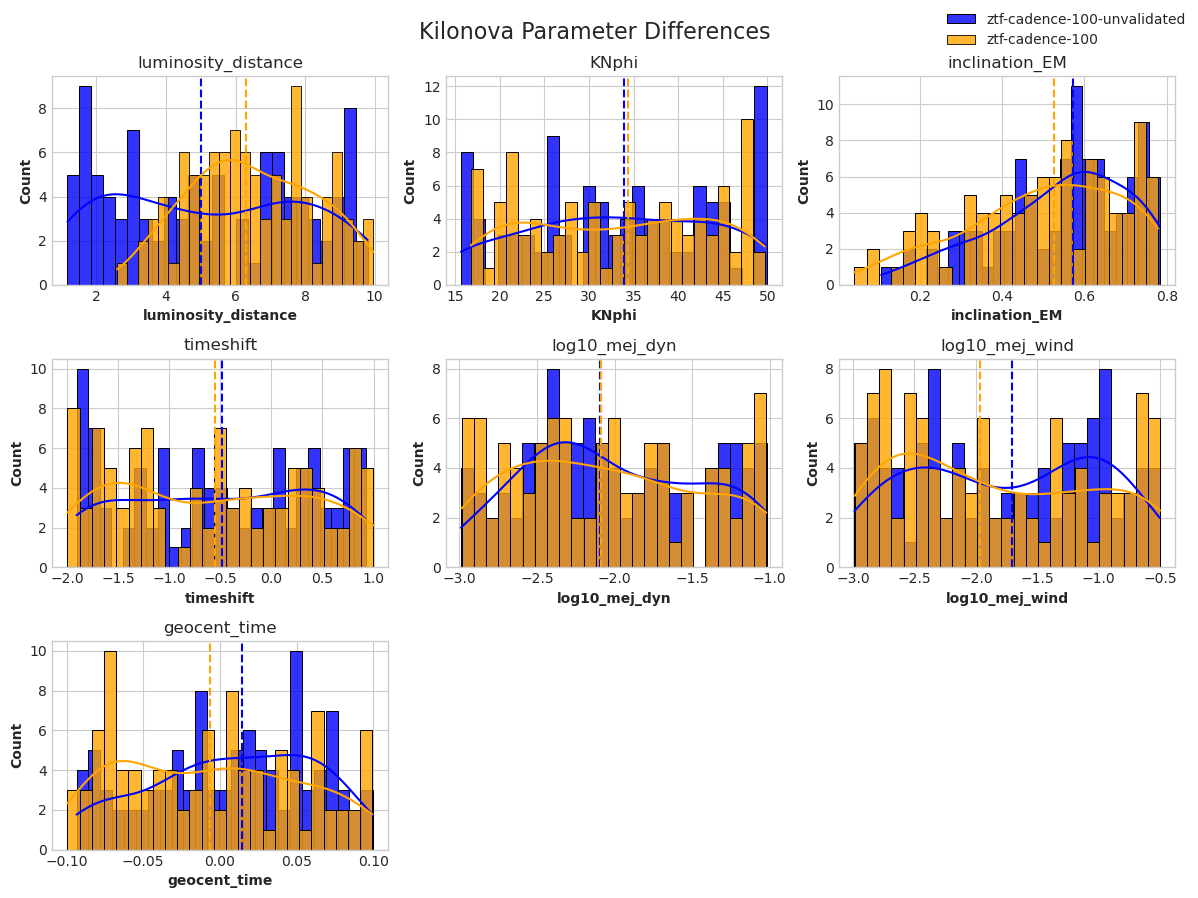

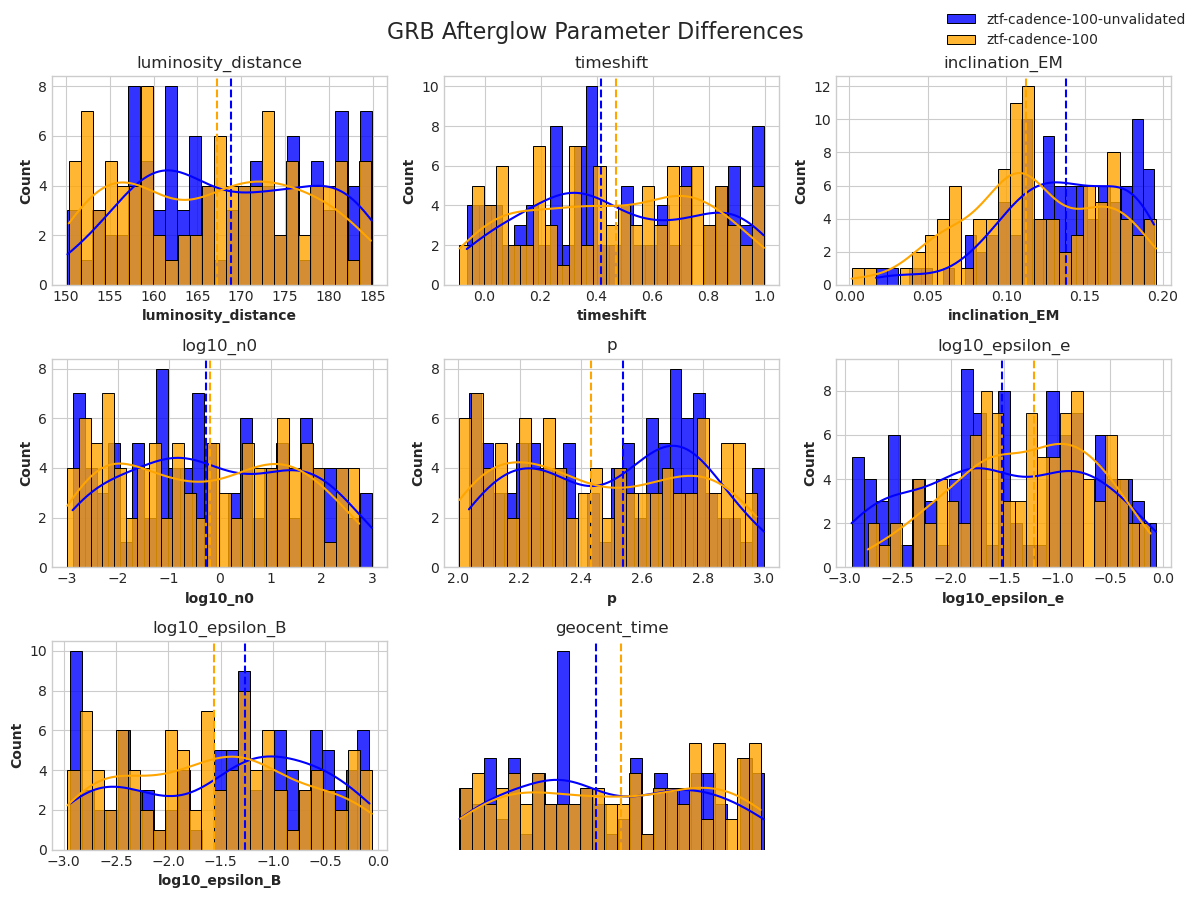

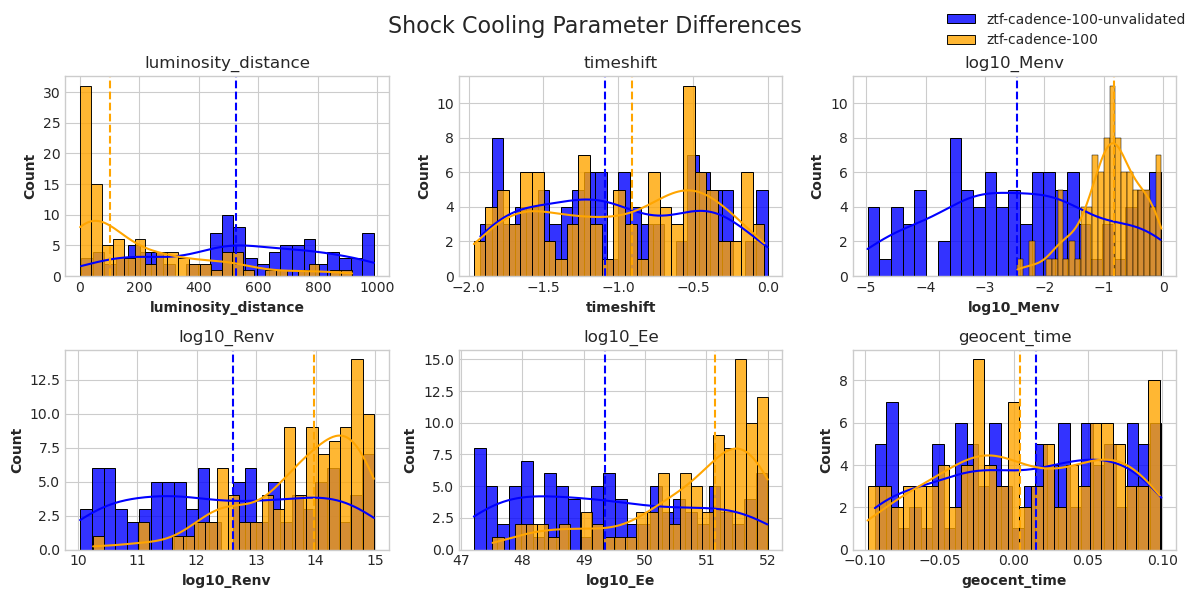

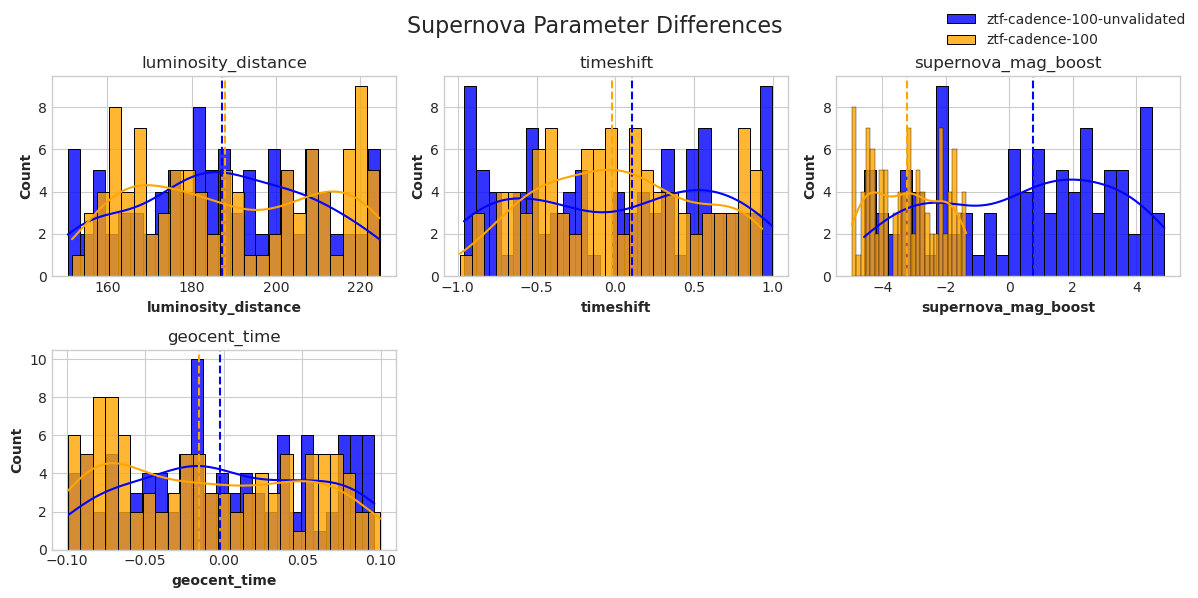

In [56]:
plot_parameter_differences(['injections/ztf-cadence-100-unvalidated','injections/ztf-cadence-100'],)